In [1]:
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter
import matplotlib as mpl
import re

mpl.rcParams['figure.dpi']= 400
sns.set_style("white")
plt.rc("font", size=12)
plt.rc("axes", titlesize=16, titleweight="bold") 

In [6]:
BASE_PATH = "../data"
RAW_DATA_PATH = f"{BASE_PATH}/raw"
FILE_PATTERN = RAW_DATA_PATH + "/*/OD*"
START_STATION = 6184
END_STATION = 6015
START_DATE = "2014-04-15"
END_DATE = "2017-11-15"
THOUSANDS_SYMBOL = " (000s)"

In [7]:
def load_data(path_pattern: str) -> pd.DataFrame:
    filepath = [pd.read_csv(name, parse_dates=["start_date", "end_date"]) for name in glob.glob(path_pattern)]
    df = pd.concat(filepath)
    return df

def create_overview_ts(dataframe: pd.DataFrame) -> pd.DataFrame: 
    df = dataframe.copy()
    df.drop(["end_date", "duration_sec", "start_station_code", "end_station_code"], axis=1, inplace=True)
    df["start_date"] = df["start_date"].dt.normalize()
    return df.set_index("start_date")

In [8]:
df = load_data(FILE_PATTERN)
df = df.loc[
        (df.start_date >= START_DATE) &
        (df.end_date < END_DATE)
    ].reset_index(drop=True)

overview = create_overview_ts(df) 

In [5]:
overview.head()

is_member
start_date           
2014-08-01          0
2014-08-01          1
2014-08-01          1
2014-08-01          1
2014-08-01          0

In [6]:
def convert_thousands(x, pos):
    return '%1.0f' % (x * 1e-3)

def set_plotting_template(ax, title:str="", thousands:bool=True, as_date=None, xlabel:str=" ", ylabel:str=" "):
    sns.despine(left=True, right=True)
    if thousands:
        formatter = FuncFormatter(convert_thousands)
        ax.get_yaxis().set_major_formatter(formatter)
        ylabel += THOUSANDS_SYMBOL
        title += THOUSANDS_SYMBOL
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)    
    ax.grid(axis='y')
    ax.set_title(title, loc="left")
    
    if as_date: 
        date_formatter = DateFormatter(as_date)
        ax.xaxis.set_major_formatter(date_formatter)
    return ax
    
def plot_ts_trends_by_year(dataframe: pd.DataFrame, start: str, end: str, freq: str):
    freq_str = {
        "M": "Monthly", 
        "D": "Daily"
    }
    daily_traffic = (
        dataframe.resample(freq)
        .count()
        .reset_index()
    )
    daily_traffic.columns = ["start_date", "num_of_trips"]
    fig, axs = plt.subplots(nrows=4, figsize=(16,12))
    
    years = daily_traffic.start_date.dt.year.unique().tolist()
    for idx, ax in enumerate(axs): 
        title = f"{freq_str[freq]} numbers of bike hires in {years[idx]}"
        start_date = re.sub("20[0-9]{2}", str(years[idx]), start)
        end_date = re.sub("20[0-9]{2}", str(years[idx]), end)
        
        ax = set_plotting_template(ax, title=title, ylabel="Number of bike hires", as_date="%d-%b")
        sns.lineplot(
            x = "start_date",
            y = "num_of_trips", 
            data=daily_traffic.loc[(daily_traffic.start_date >= start_date) & (daily_traffic.start_date <= end_date)],
            marker="o",
            ax=ax
        )
    plt.tight_layout()

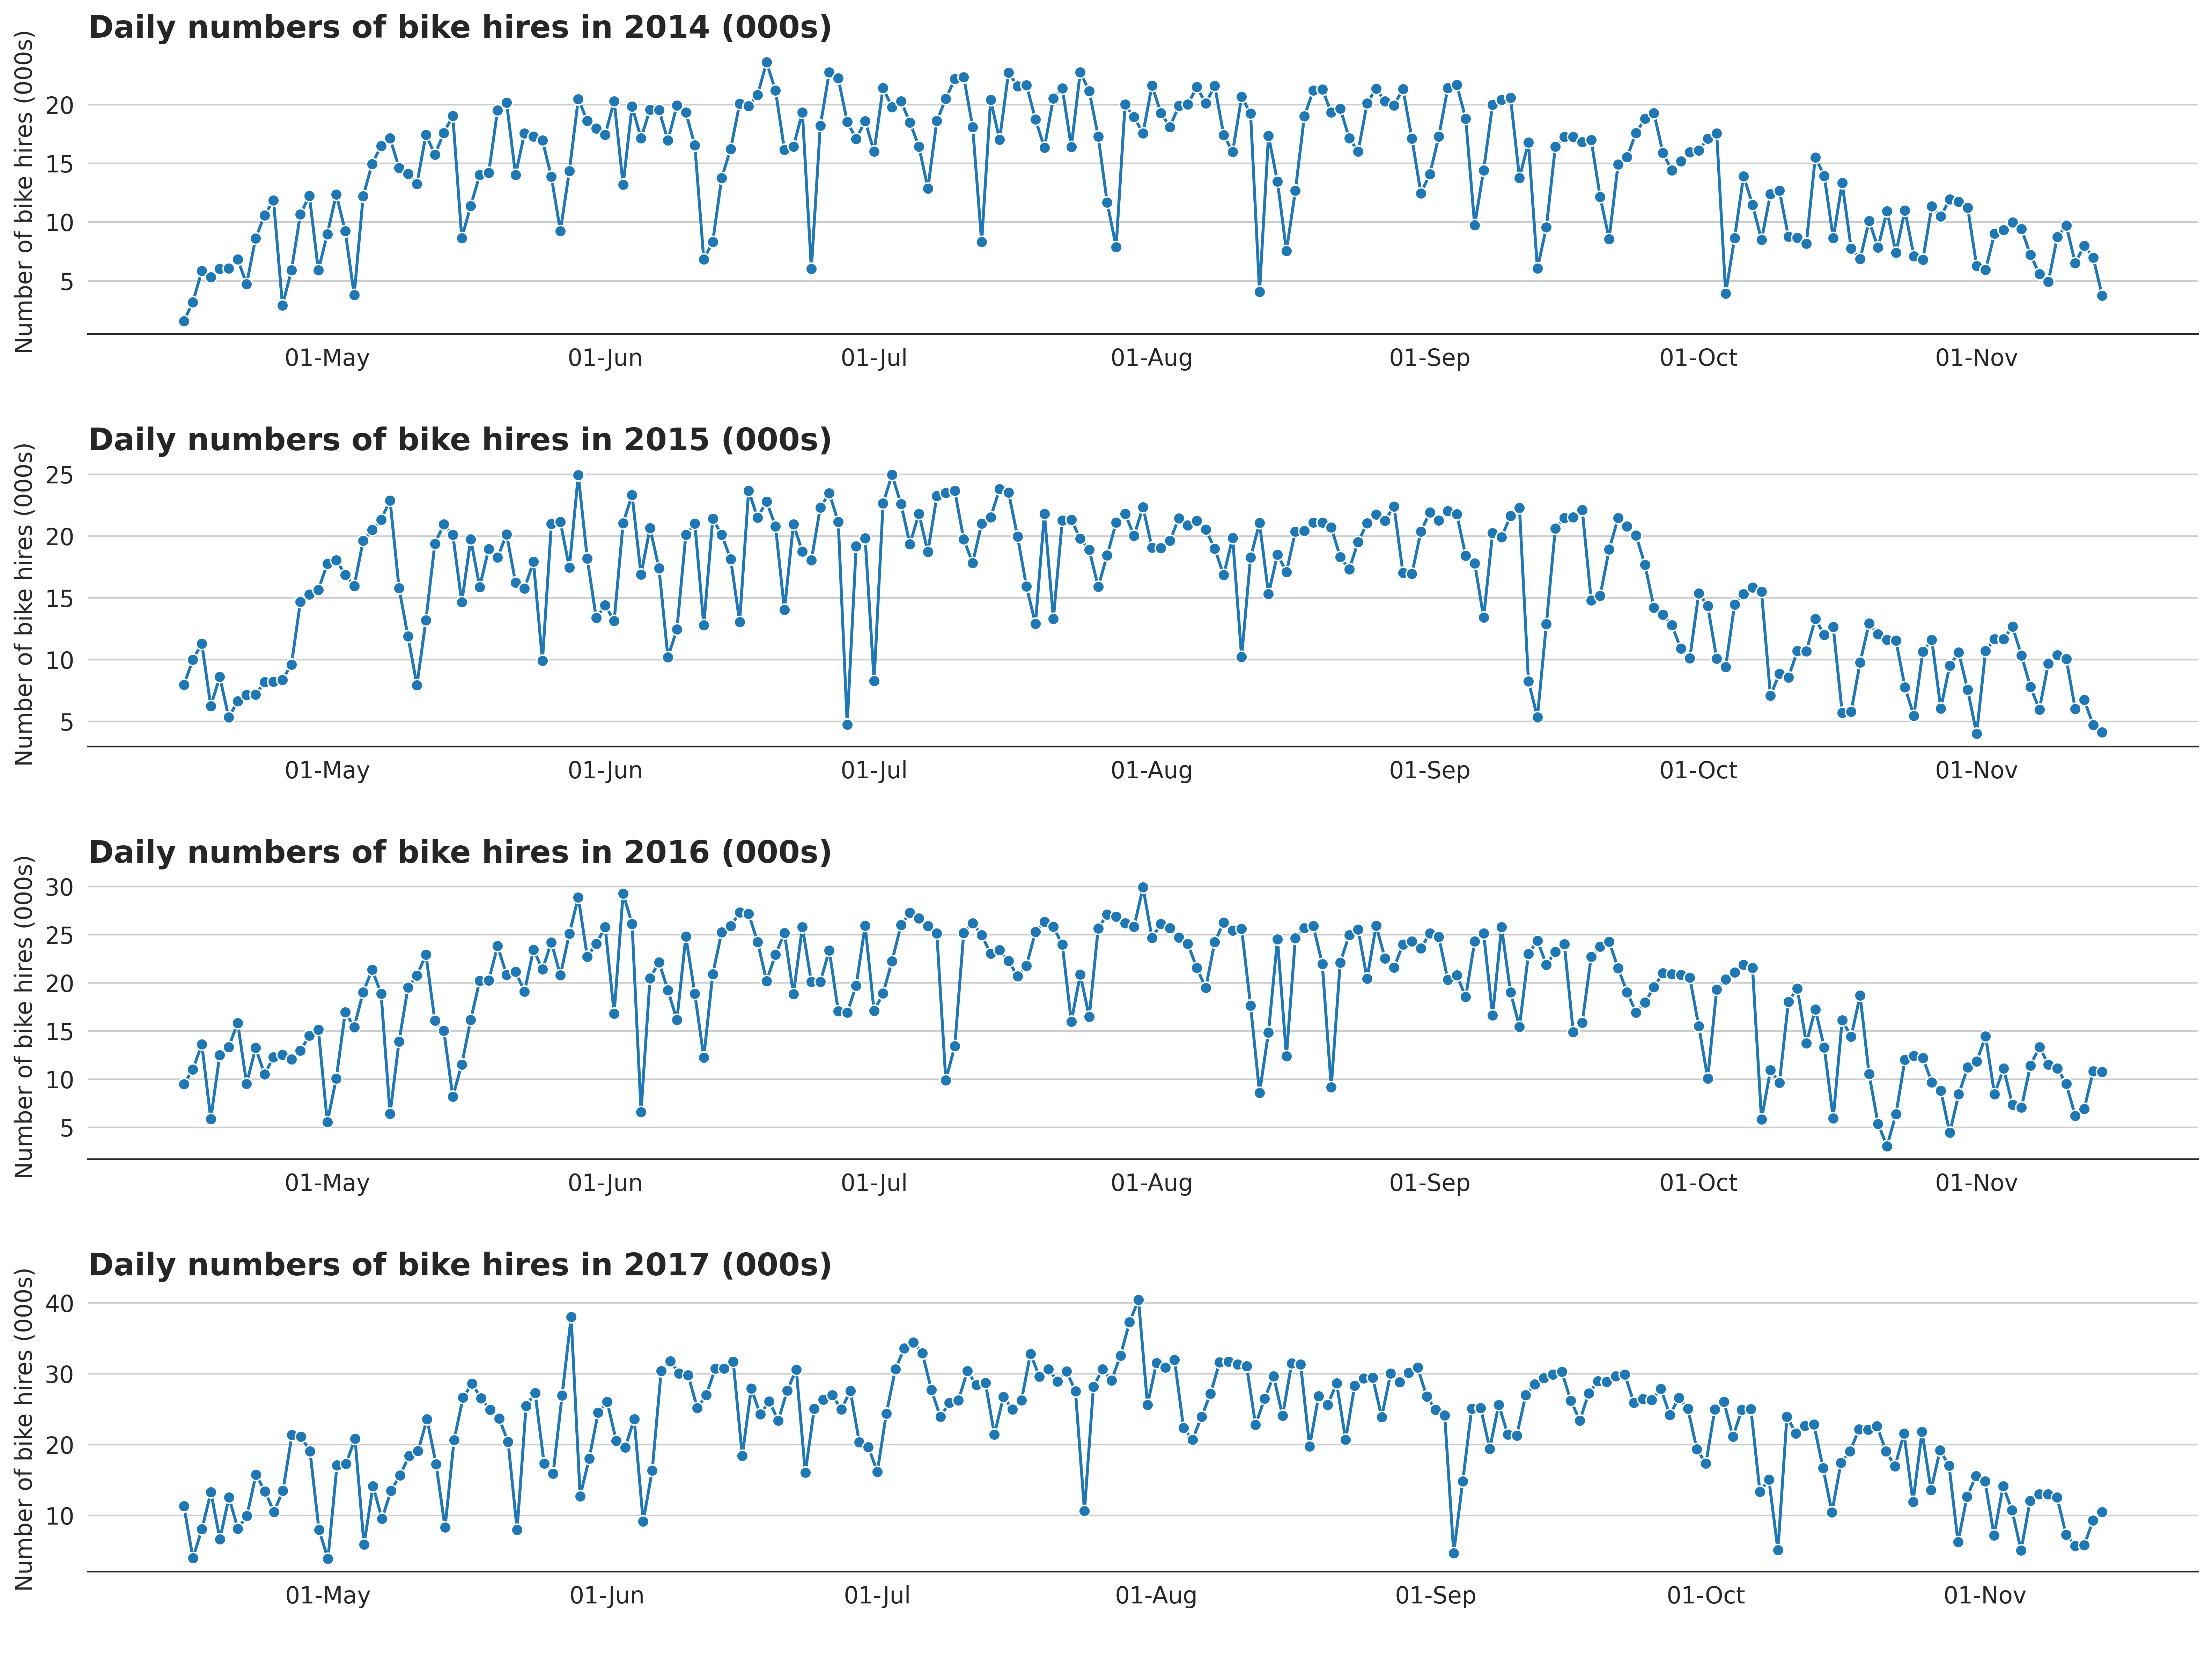

In [7]:
plot_ts_trends_by_year(overview, start=START_DATE, end=END_DATE, freq="D")

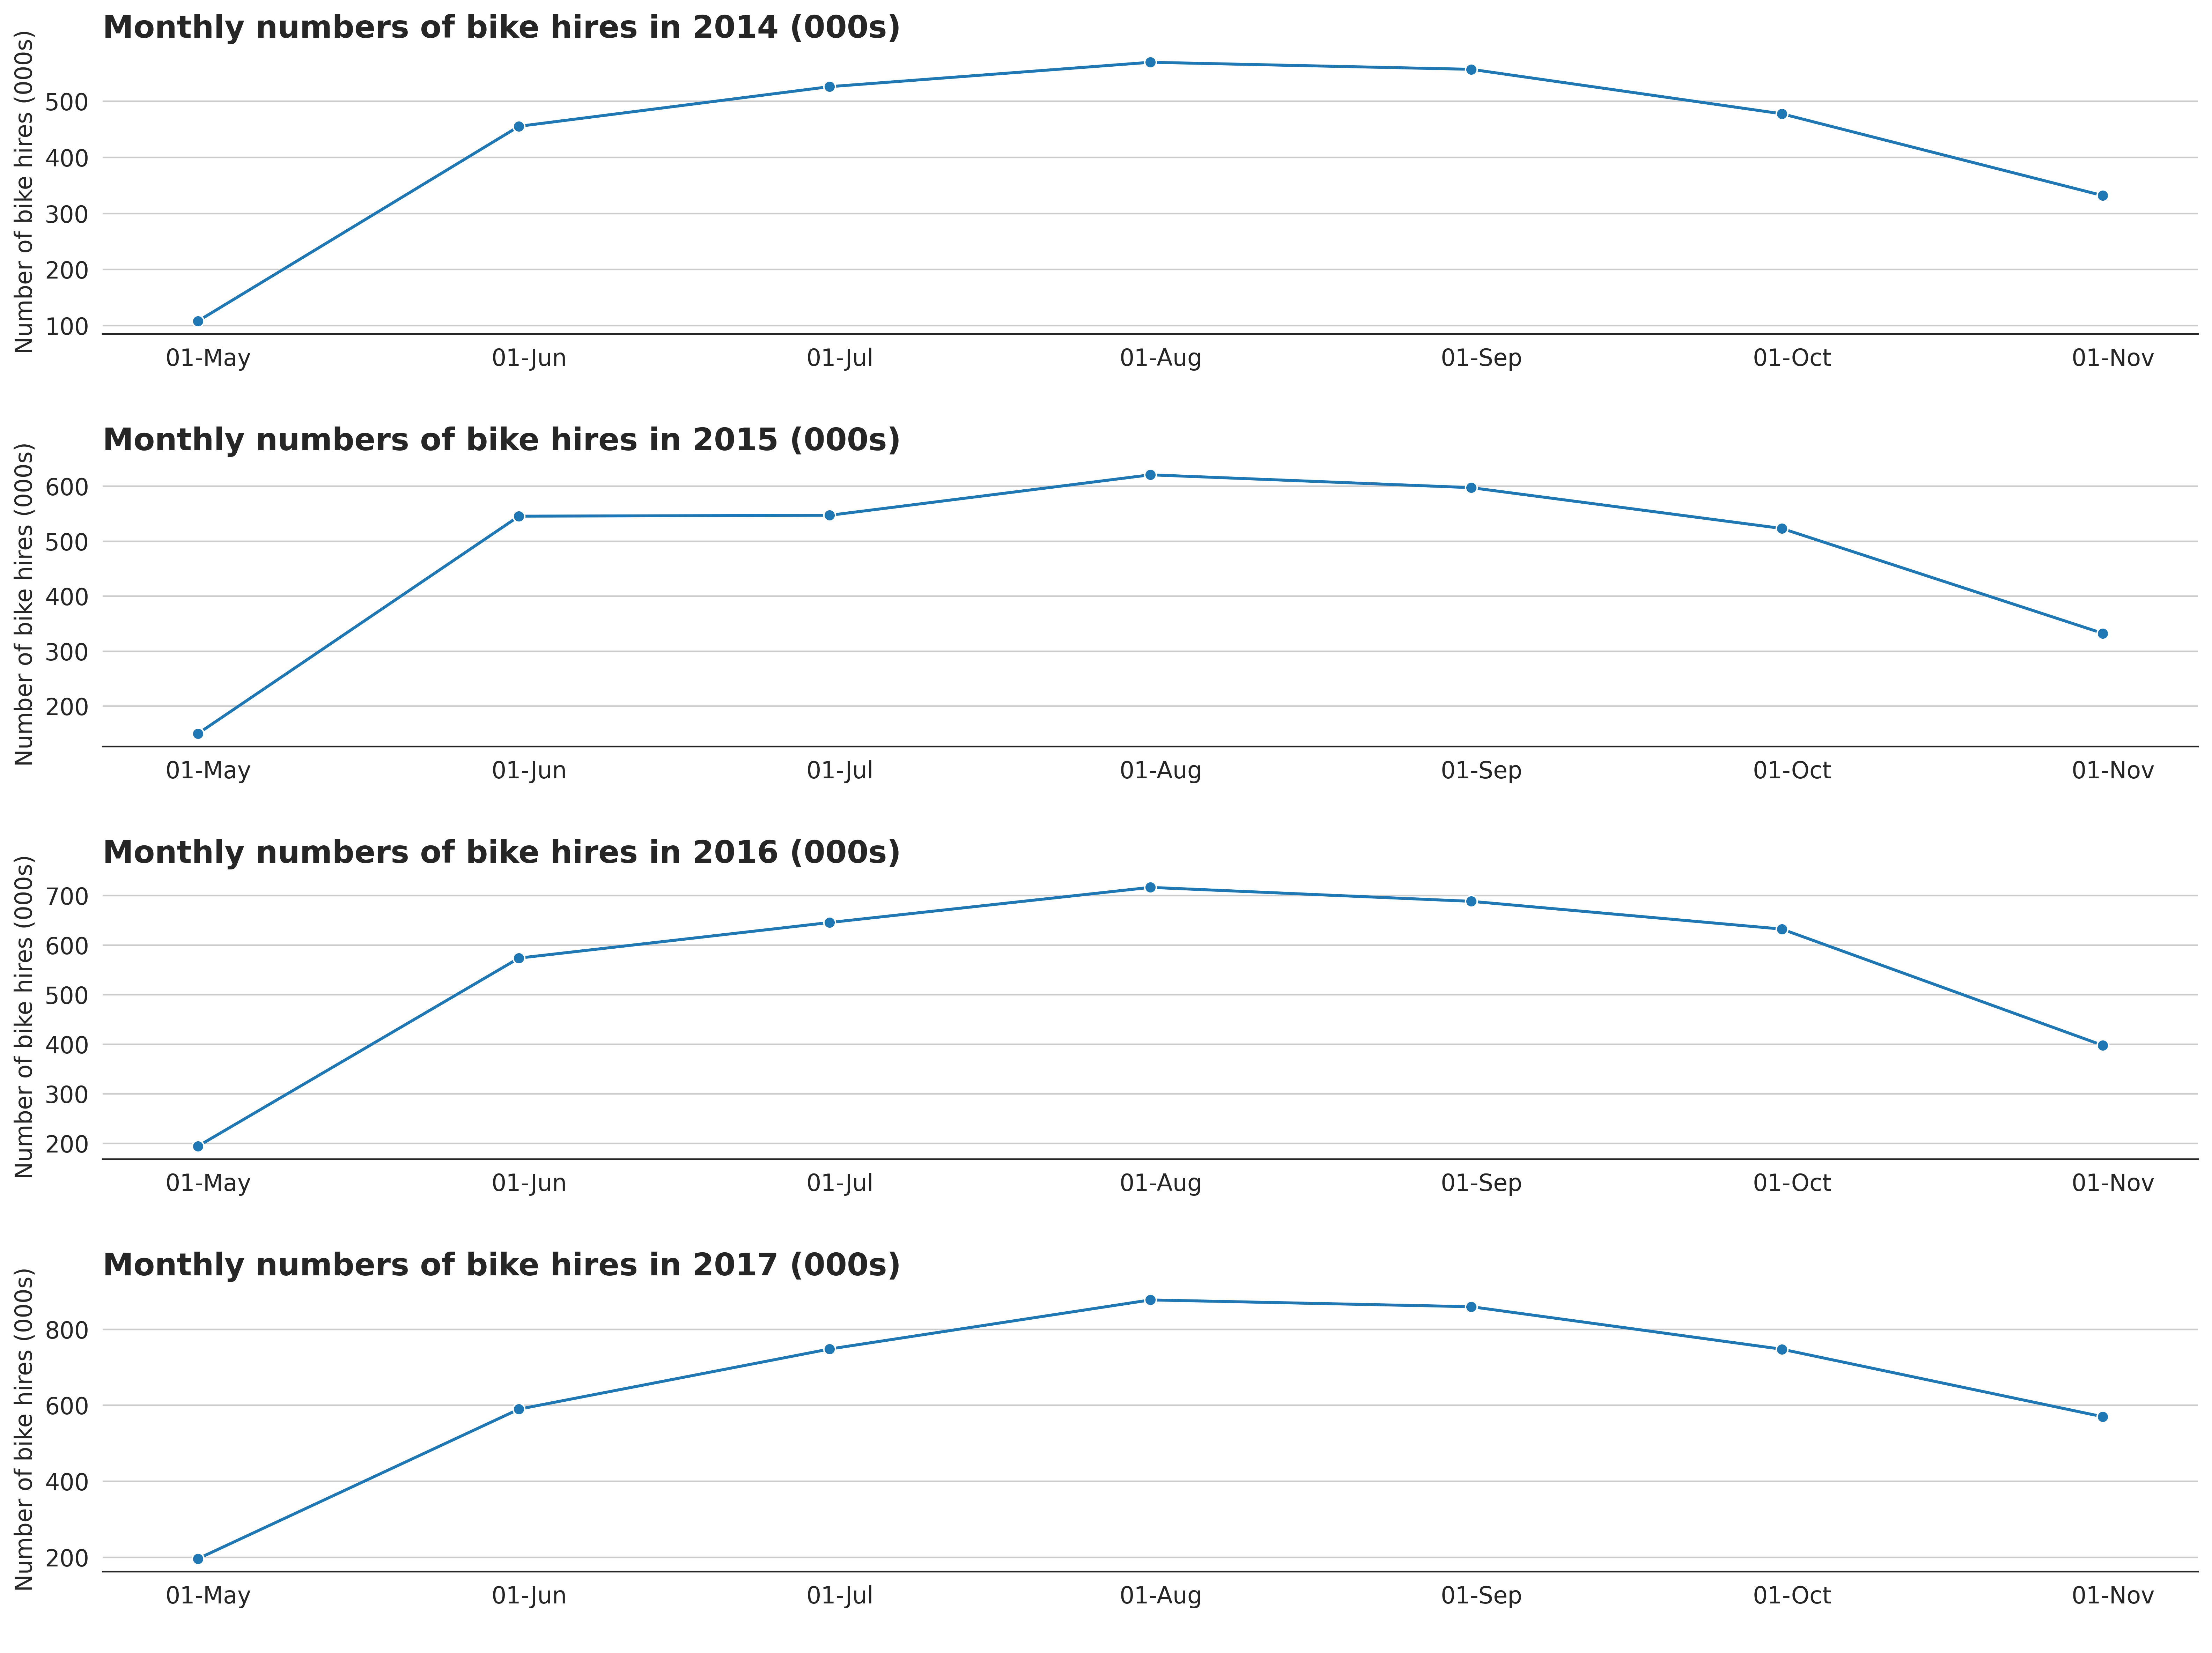

In [8]:
plot_ts_trends_by_year(overview, start=START_DATE, end=END_DATE, freq="M")

In [9]:
overview.head()

is_member
start_date           
2014-08-01          0
2014-08-01          1
2014-08-01          1
2014-08-01          1
2014-08-01          0

In [10]:
def plot_barchart_averages(counts_avg: pd.DataFrame, title=None, ylabel=None, xlabel=None):
    counts_avg.columns = ["date", "counts"]
    counts_avg = counts_avg.loc[counts_avg.counts != 0]
    fig, ax = plt.subplots(figsize= (16, 4))
    ax = sns.barplot(x="date", y="counts", data = counts_avg, color="royalblue")
    ax = set_plotting_template(ax, title=title, ylabel=ylabel, xlabel=xlabel)

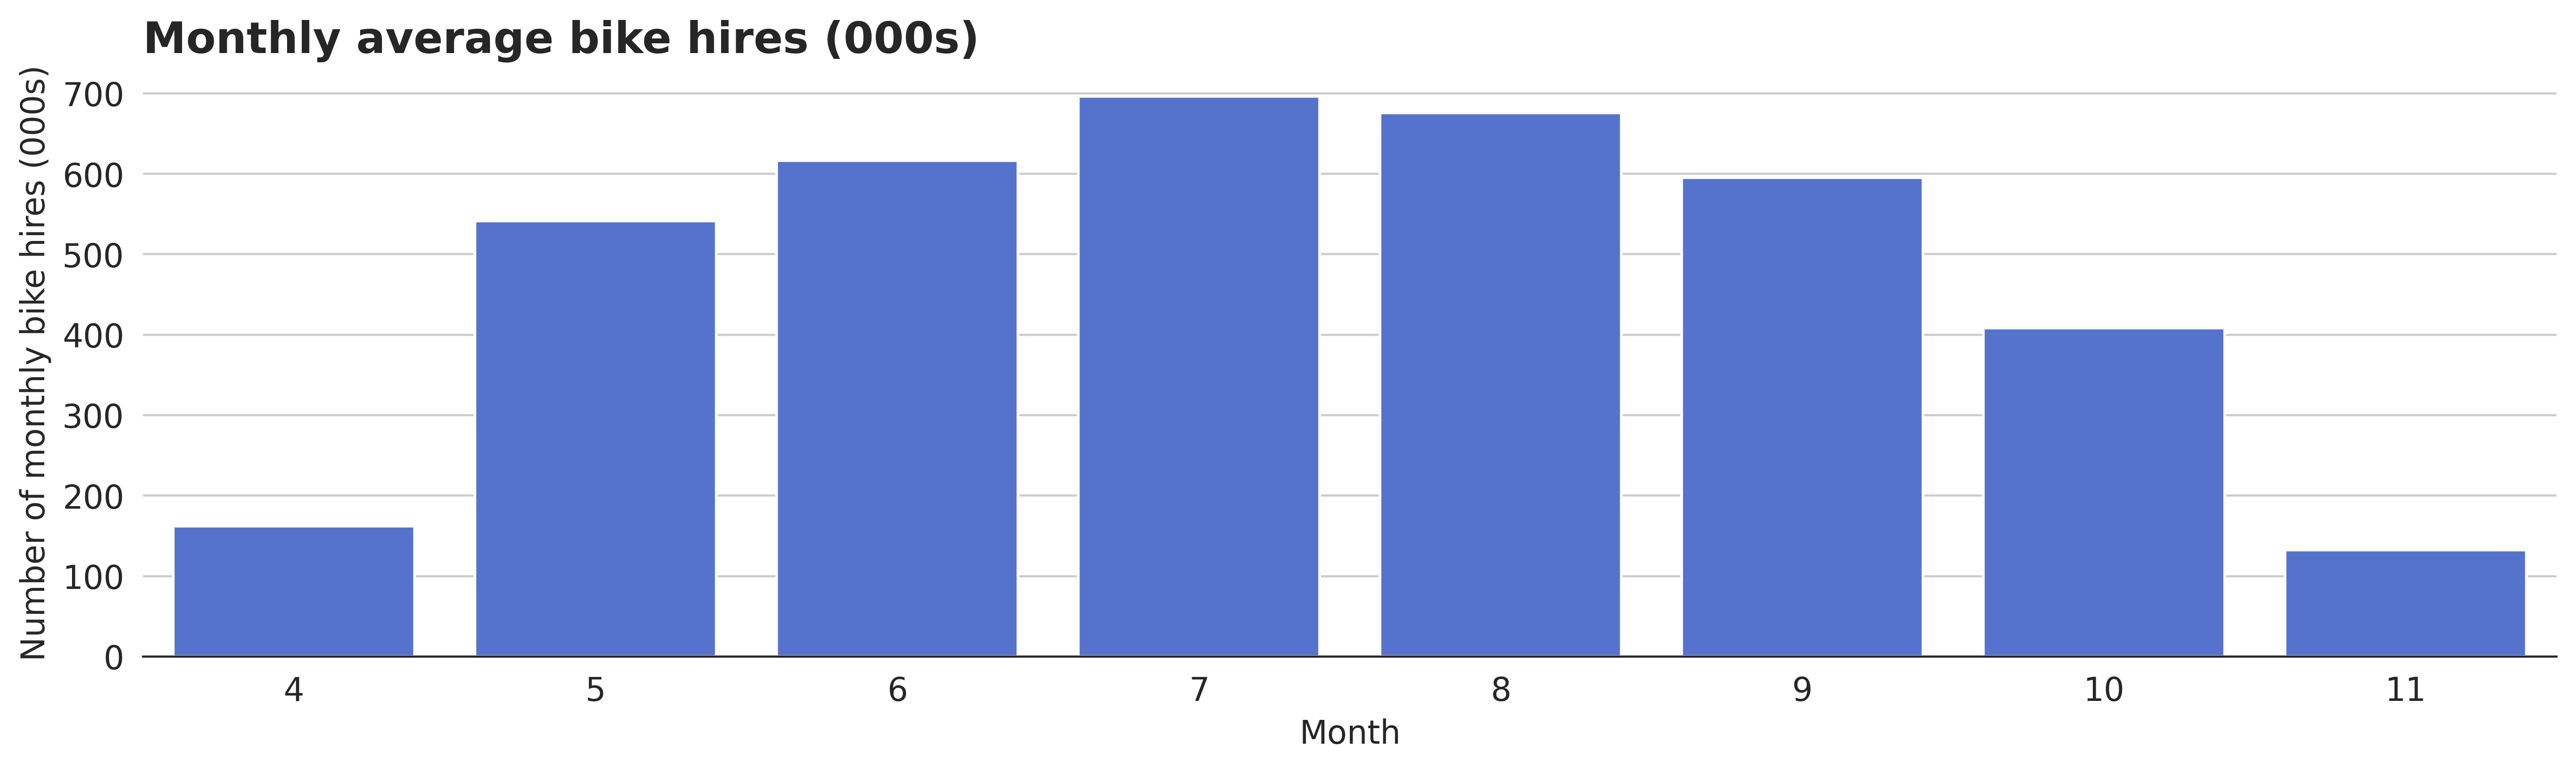

In [11]:
monthly_counts = overview.resample("M").count()
monthly_avg = monthly_counts.groupby(monthly_counts.index.month).mean().reset_index()
plot_barchart_averages(
    monthly_avg, 
    title="Monthly average bike hires", 
    ylabel="Number of monthly bike hires", 
    xlabel="Month")

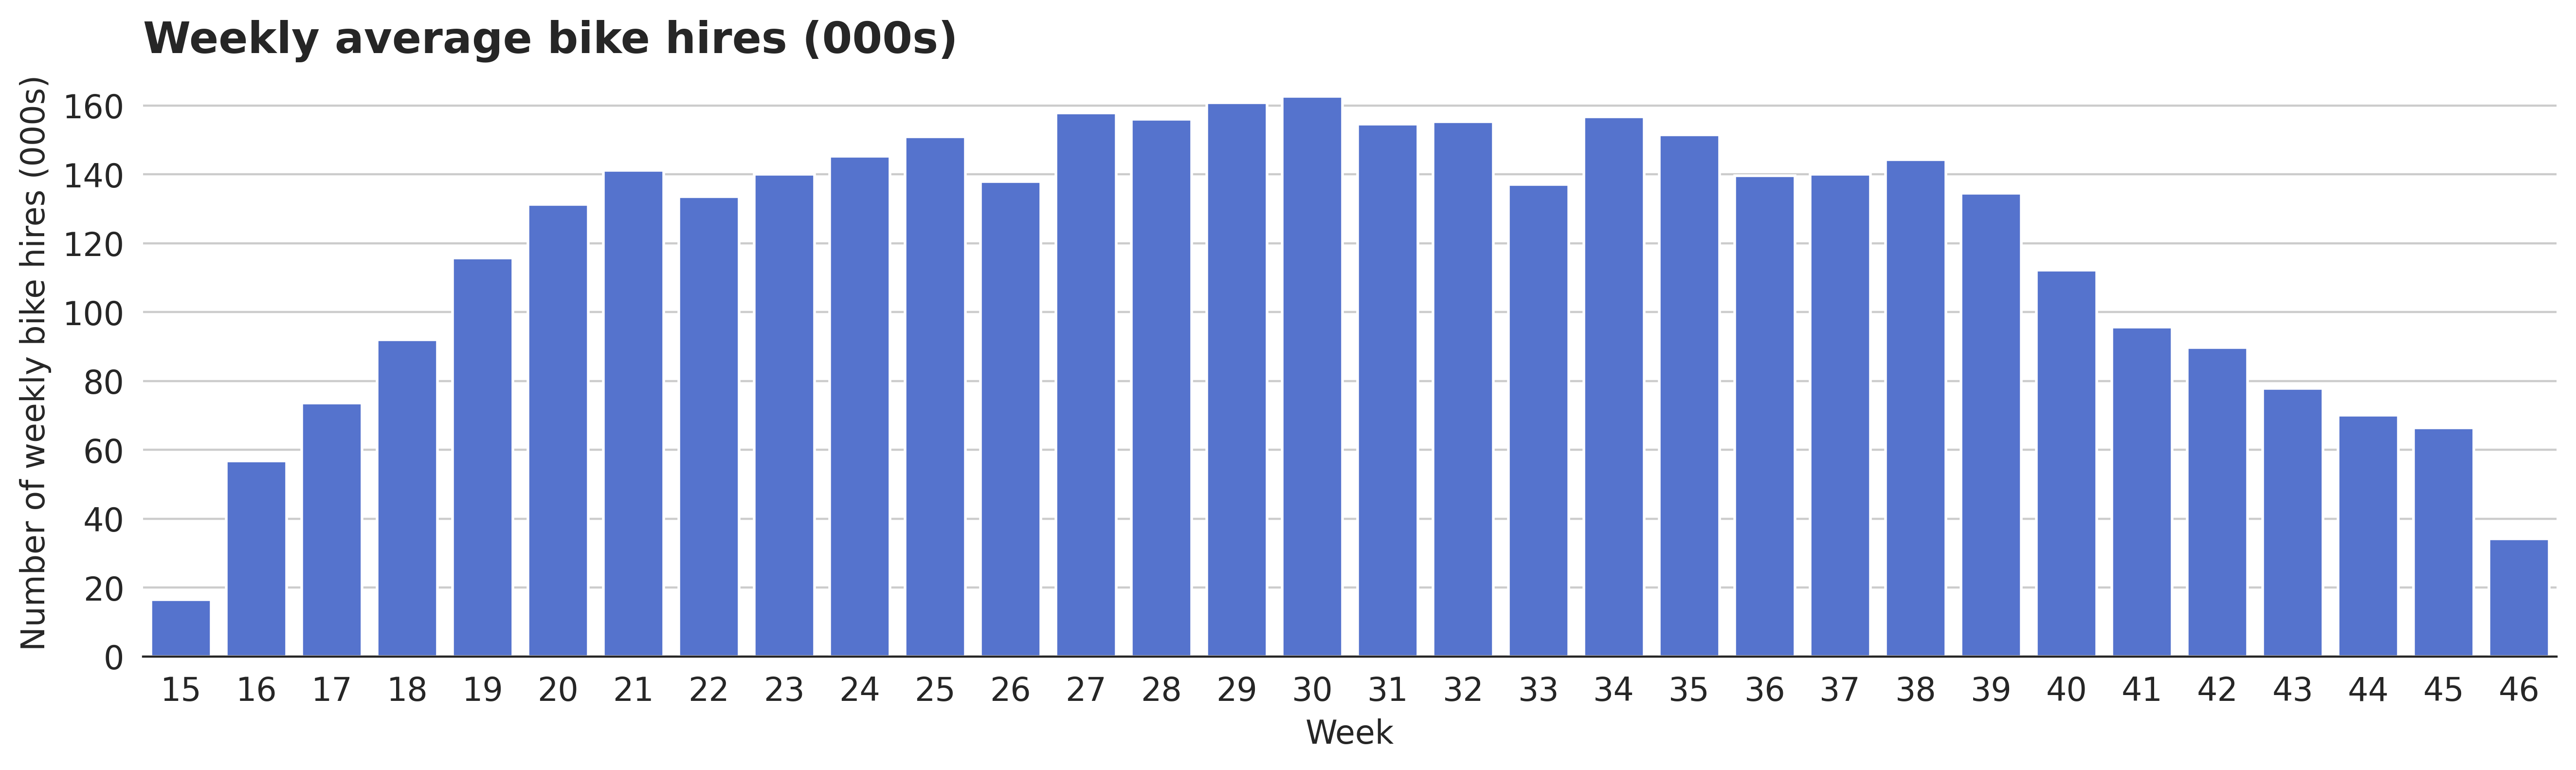

In [12]:
weekly_counts = overview.resample("W").count()
weekly_avg = weekly_counts.groupby(weekly_counts.index.isocalendar().week).mean().reset_index()
plot_barchart_averages(
    weekly_avg, 
    title="Weekly average bike hires", 
    ylabel="Number of weekly bike hires", 
    xlabel="Week")

In [13]:
monthly_counts_per_member = overview.groupby("is_member").resample("M").count()
monthly_avg_per_member = monthly_counts_per_member.groupby(
    [monthly_counts_per_member.index.get_level_values(0), 
     monthly_counts_per_member.index.get_level_values(1).month]).mean()
monthly_avg_per_member.columns = ["avg_counts"]
monthly_avg_per_member.reset_index(inplace=True)

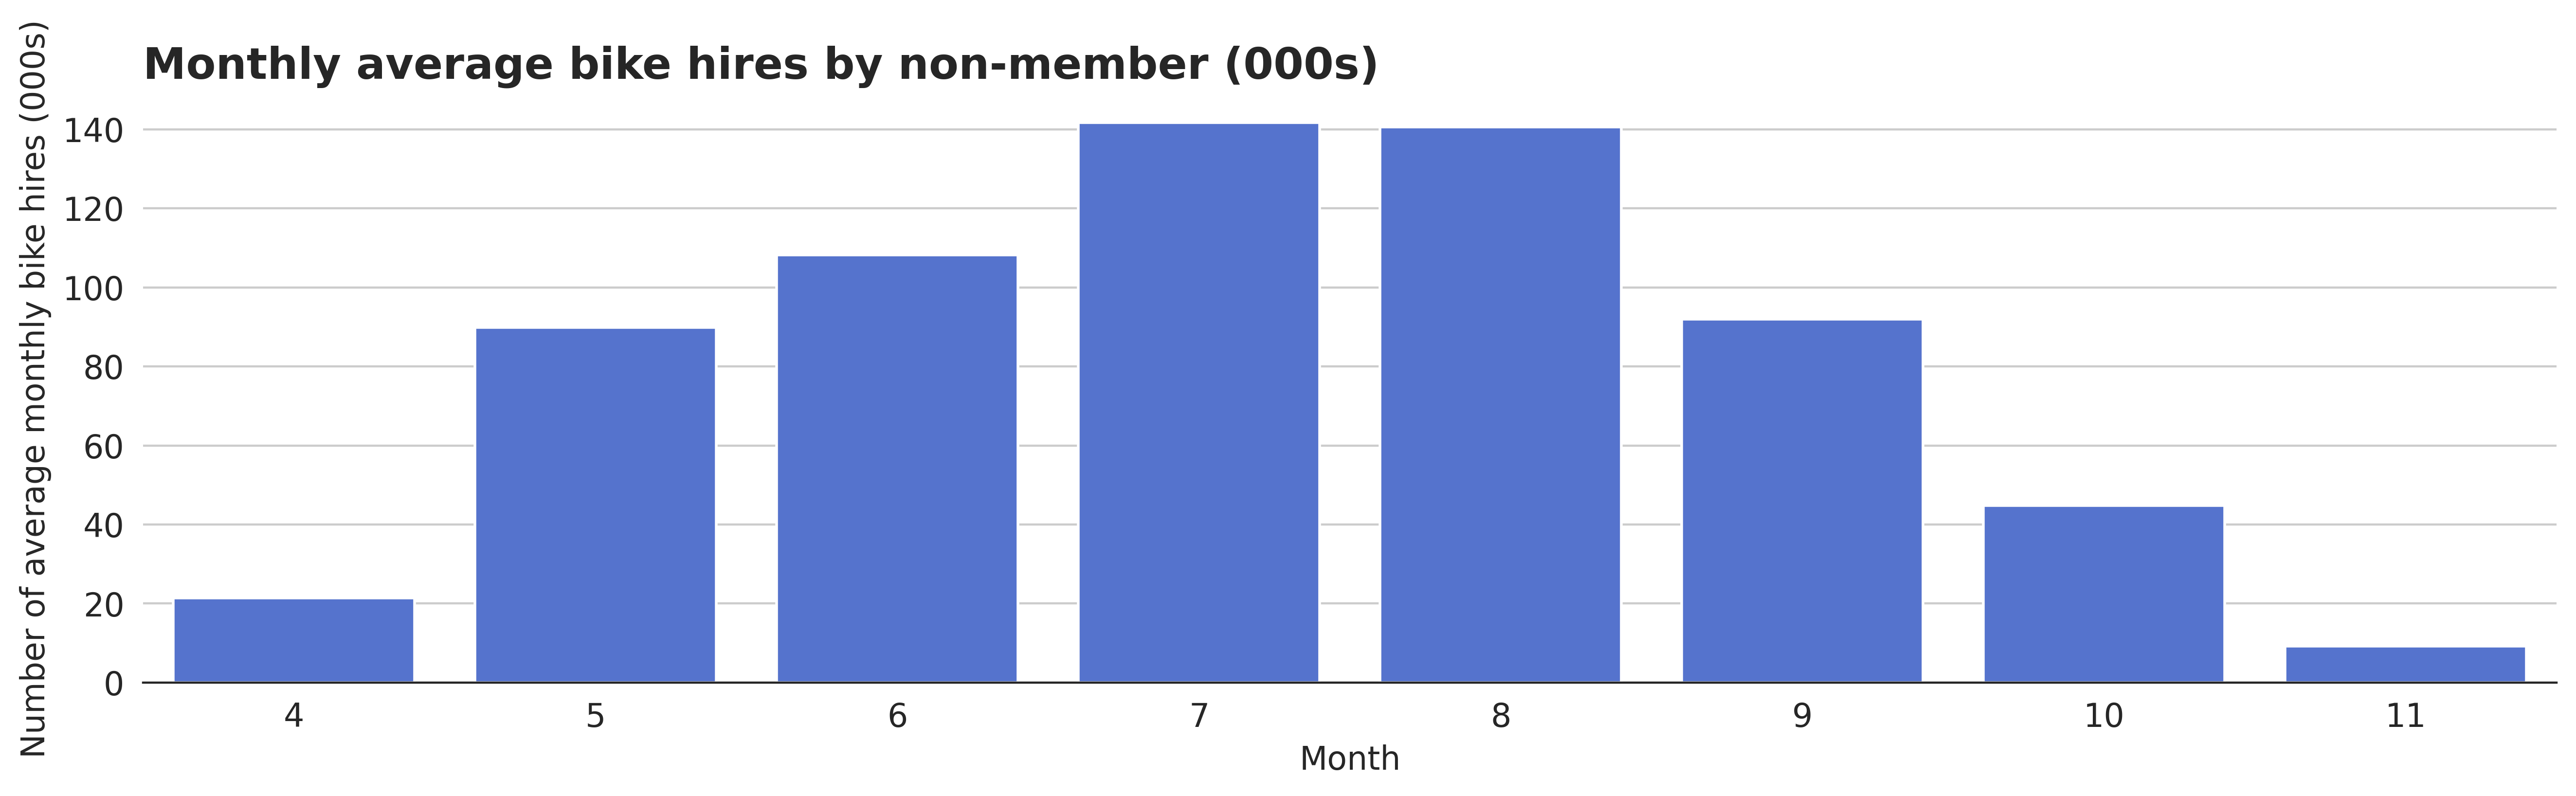

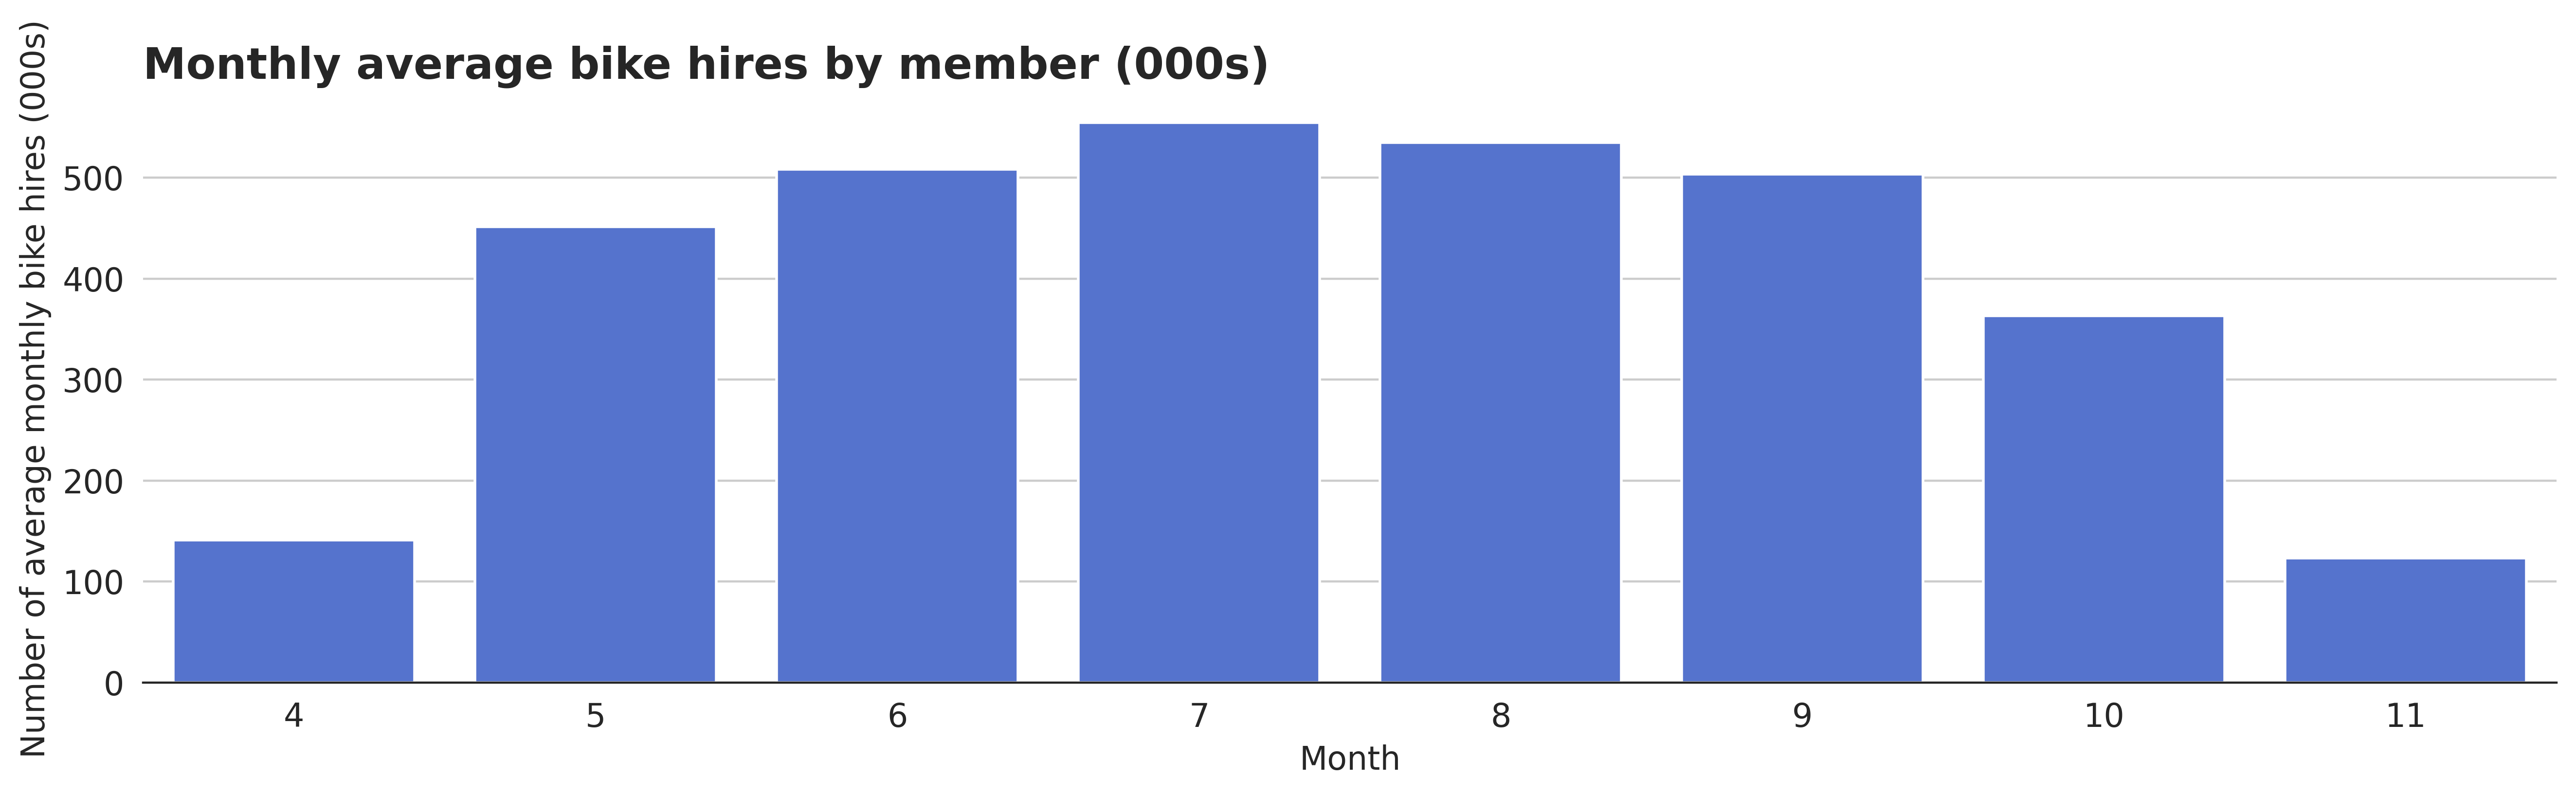

In [14]:
membership = ["non-member", "member"]
for idx, _ in enumerate(membership): 
    plot_barchart_averages(
    monthly_avg_per_member.loc[monthly_avg_per_member.is_member==idx, ["start_date", "avg_counts"]],
    title=f"Monthly average bike hires by {membership[idx]}",
    ylabel="Number of average monthly bike hires",
    xlabel="Month")

In [15]:
weekly_counts_per_member = overview.groupby("is_member").resample("W").count()
weekly_counts_per_member.columns = ["counts"]
weekly_counts_per_member.reset_index(inplace=True)
weekly_counts_per_member.columns = ["is_member", "start_date", "counts"]
weekly_avg_per_member = weekly_counts_per_member.groupby(["is_member", weekly_counts_per_member["start_date"].dt.isocalendar().week]).mean()
weekly_avg_per_member.columns = ["avg_counts"]
weekly_avg_per_member.reset_index(inplace=True)

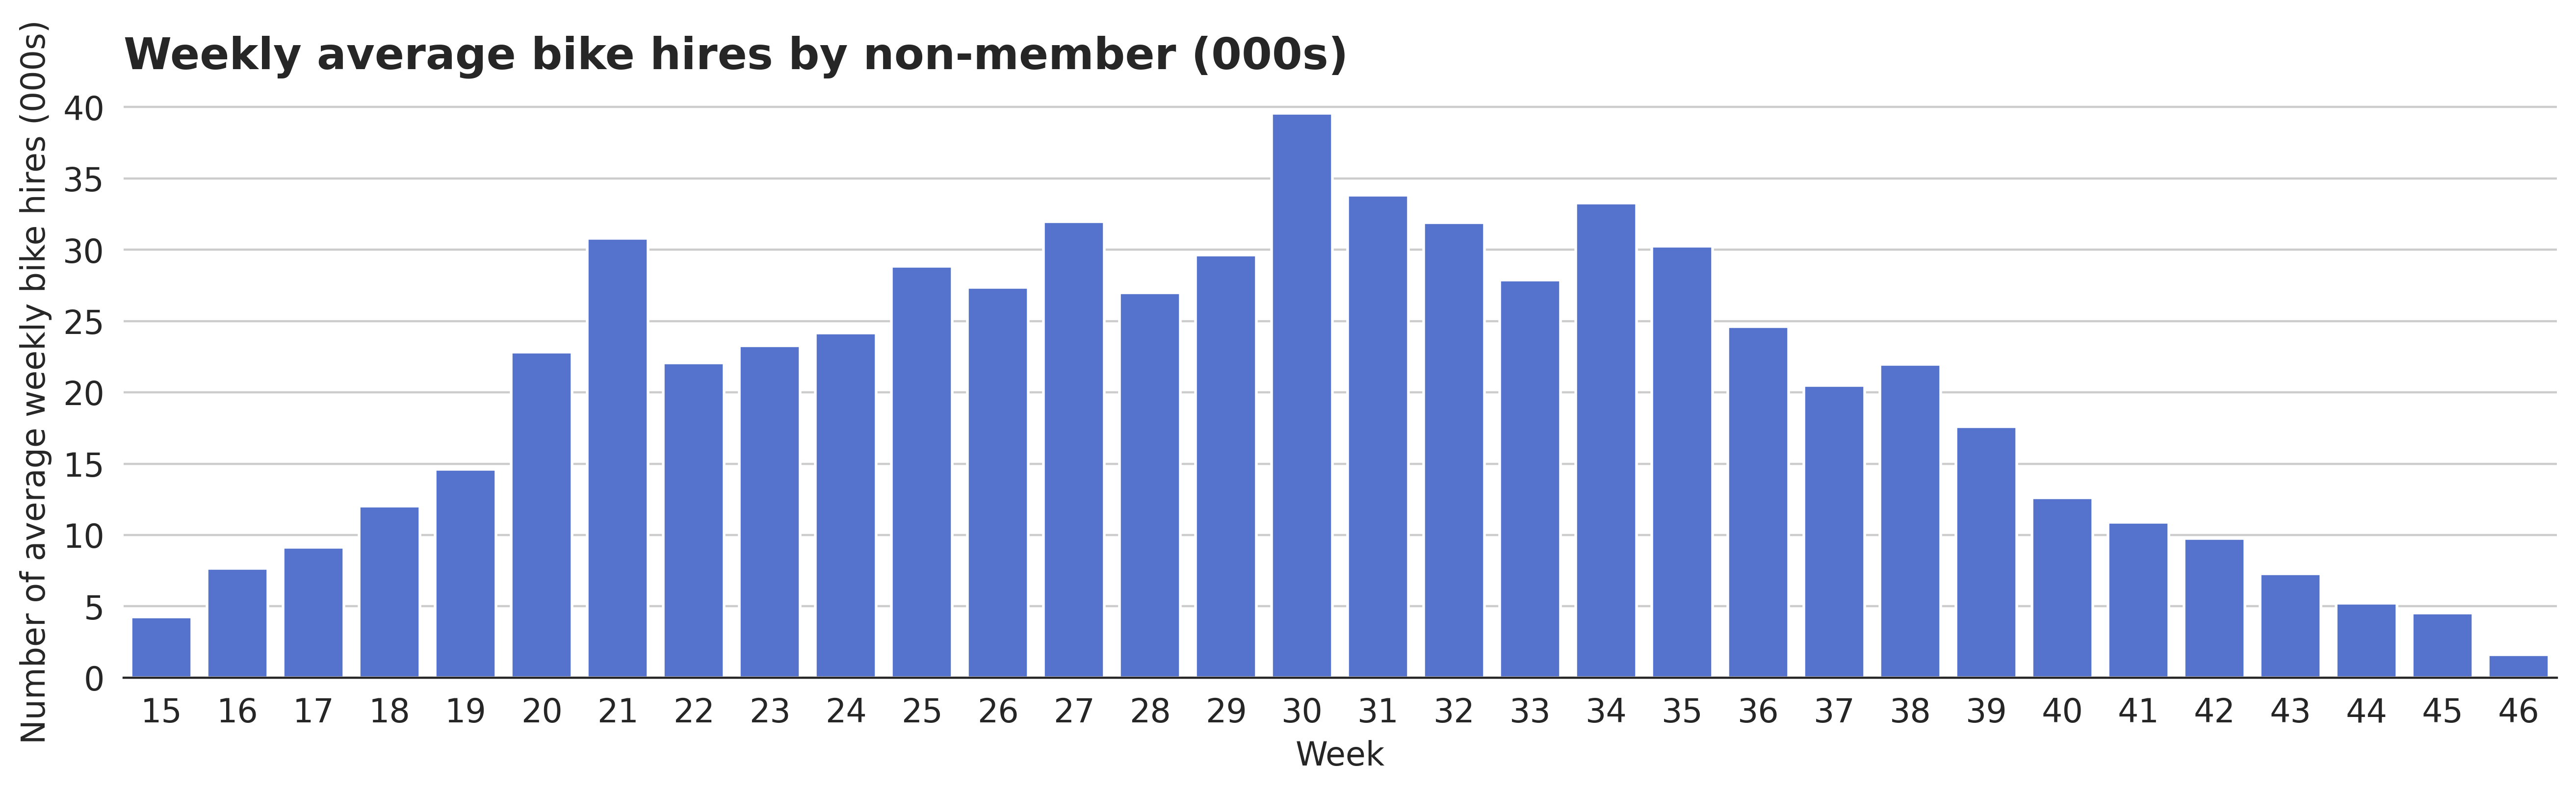

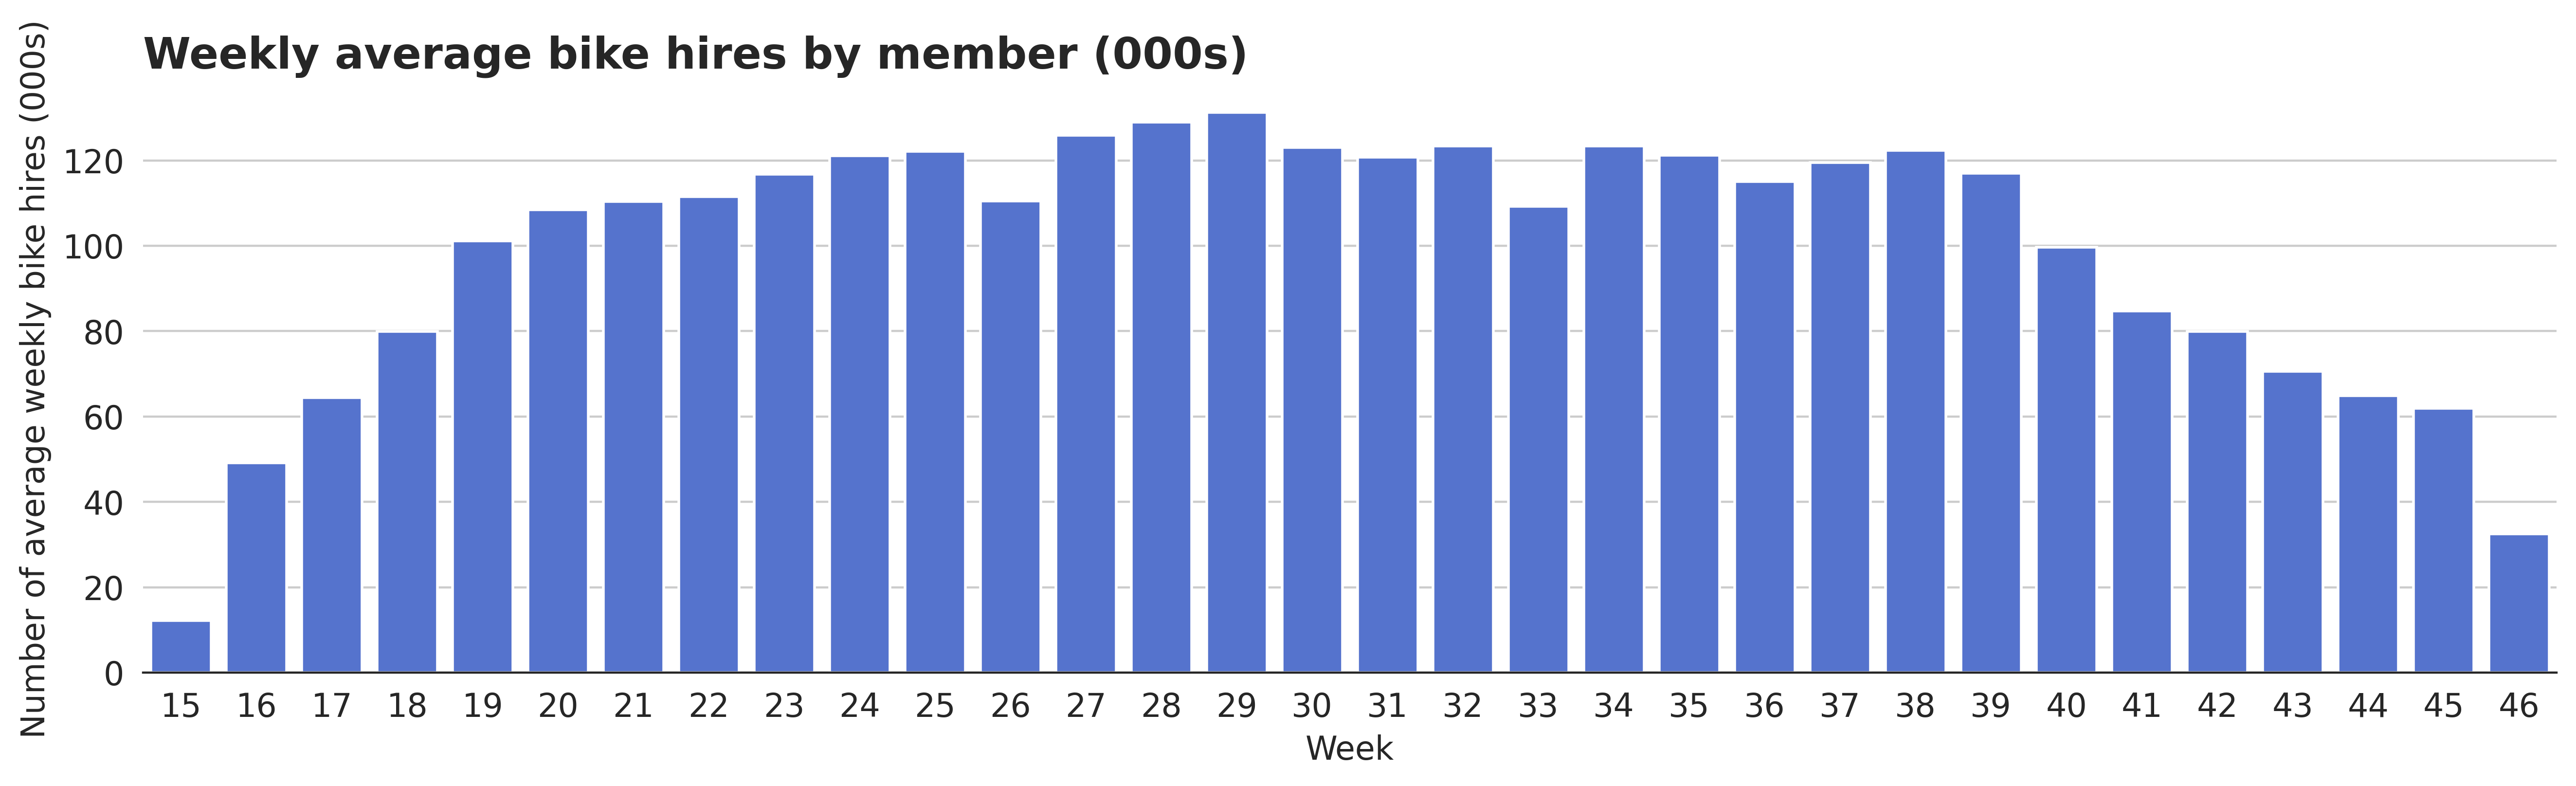

In [16]:
for idx, _ in enumerate(membership): 
    plot_barchart_averages(
        weekly_avg_per_member.loc[weekly_avg_per_member.is_member==idx, ["week", "avg_counts"]],
        title=f"Weekly average bike hires by {membership[idx]}",
        ylabel="Number of average weekly bike hires",
        xlabel="Week")

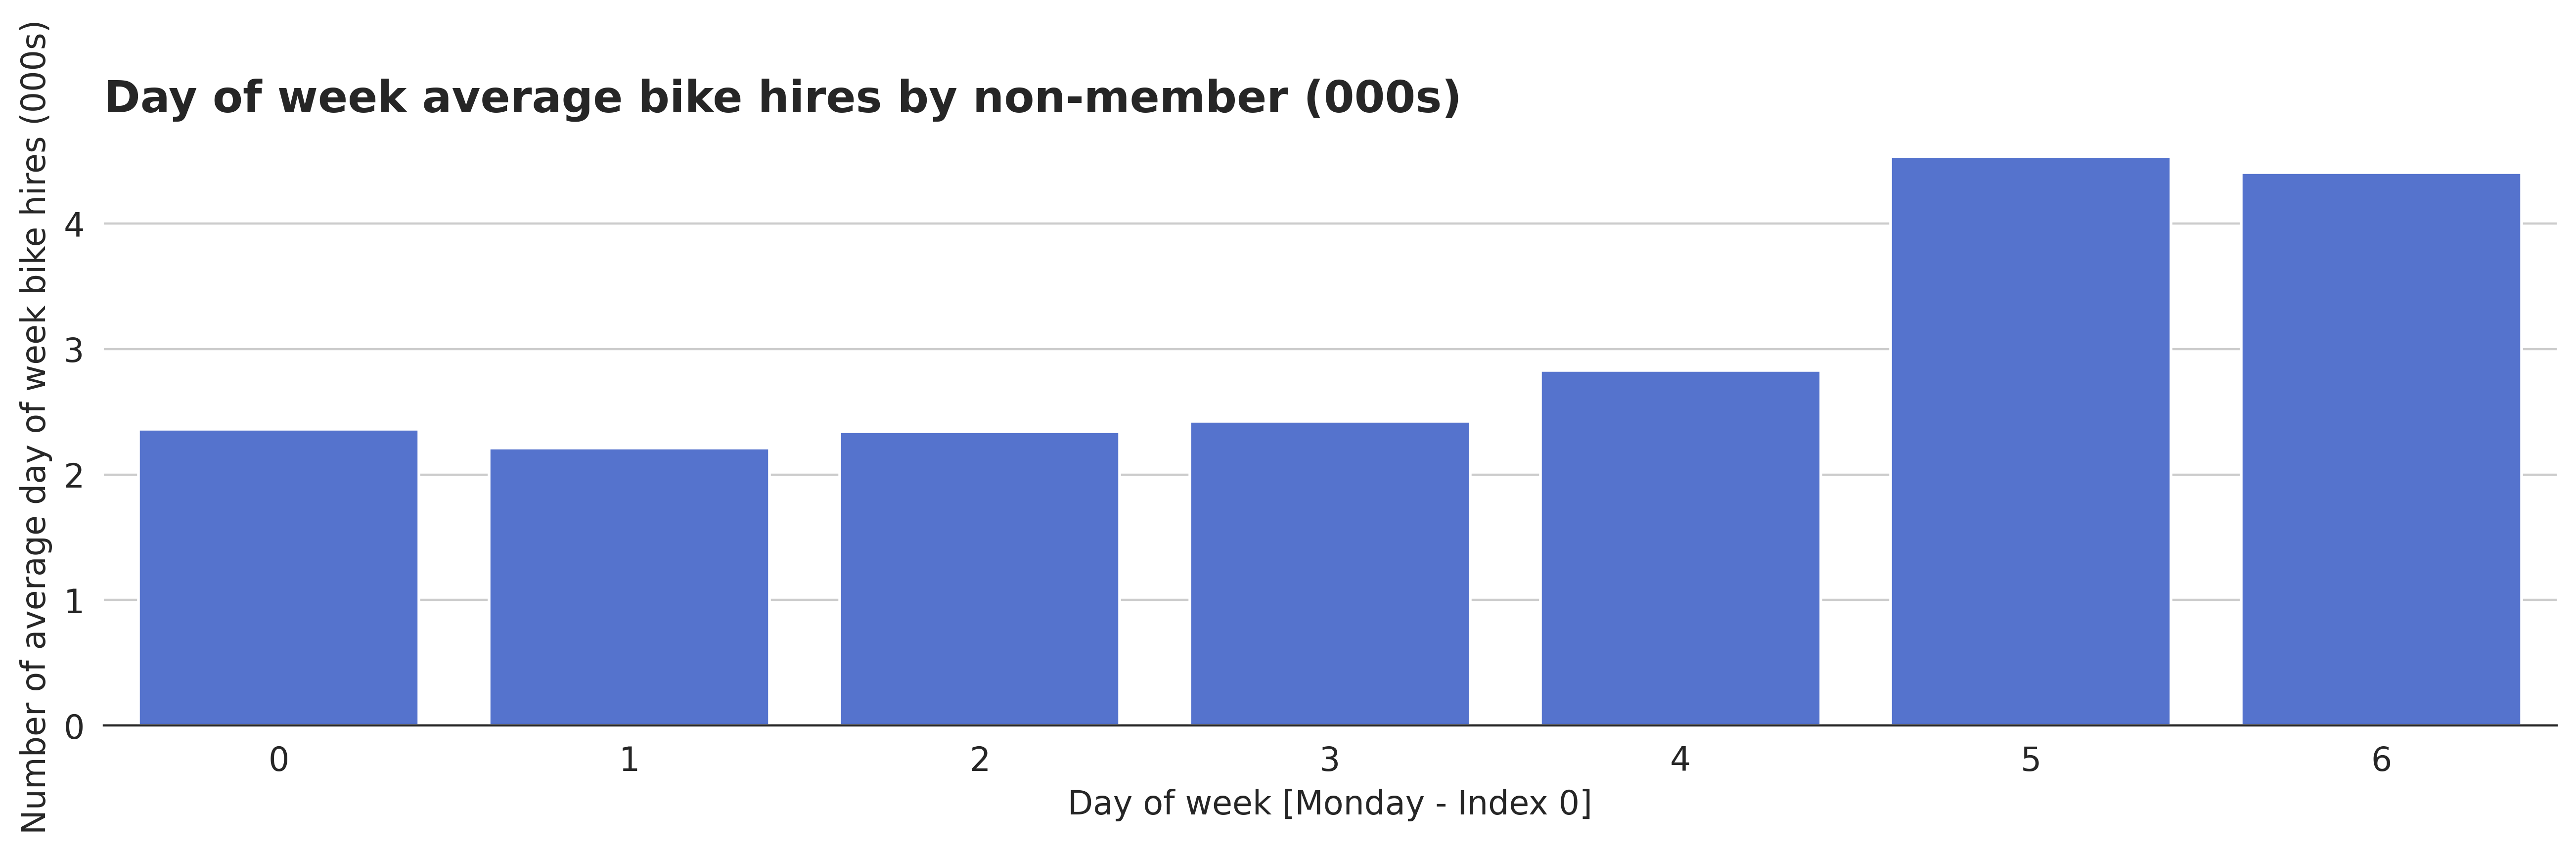

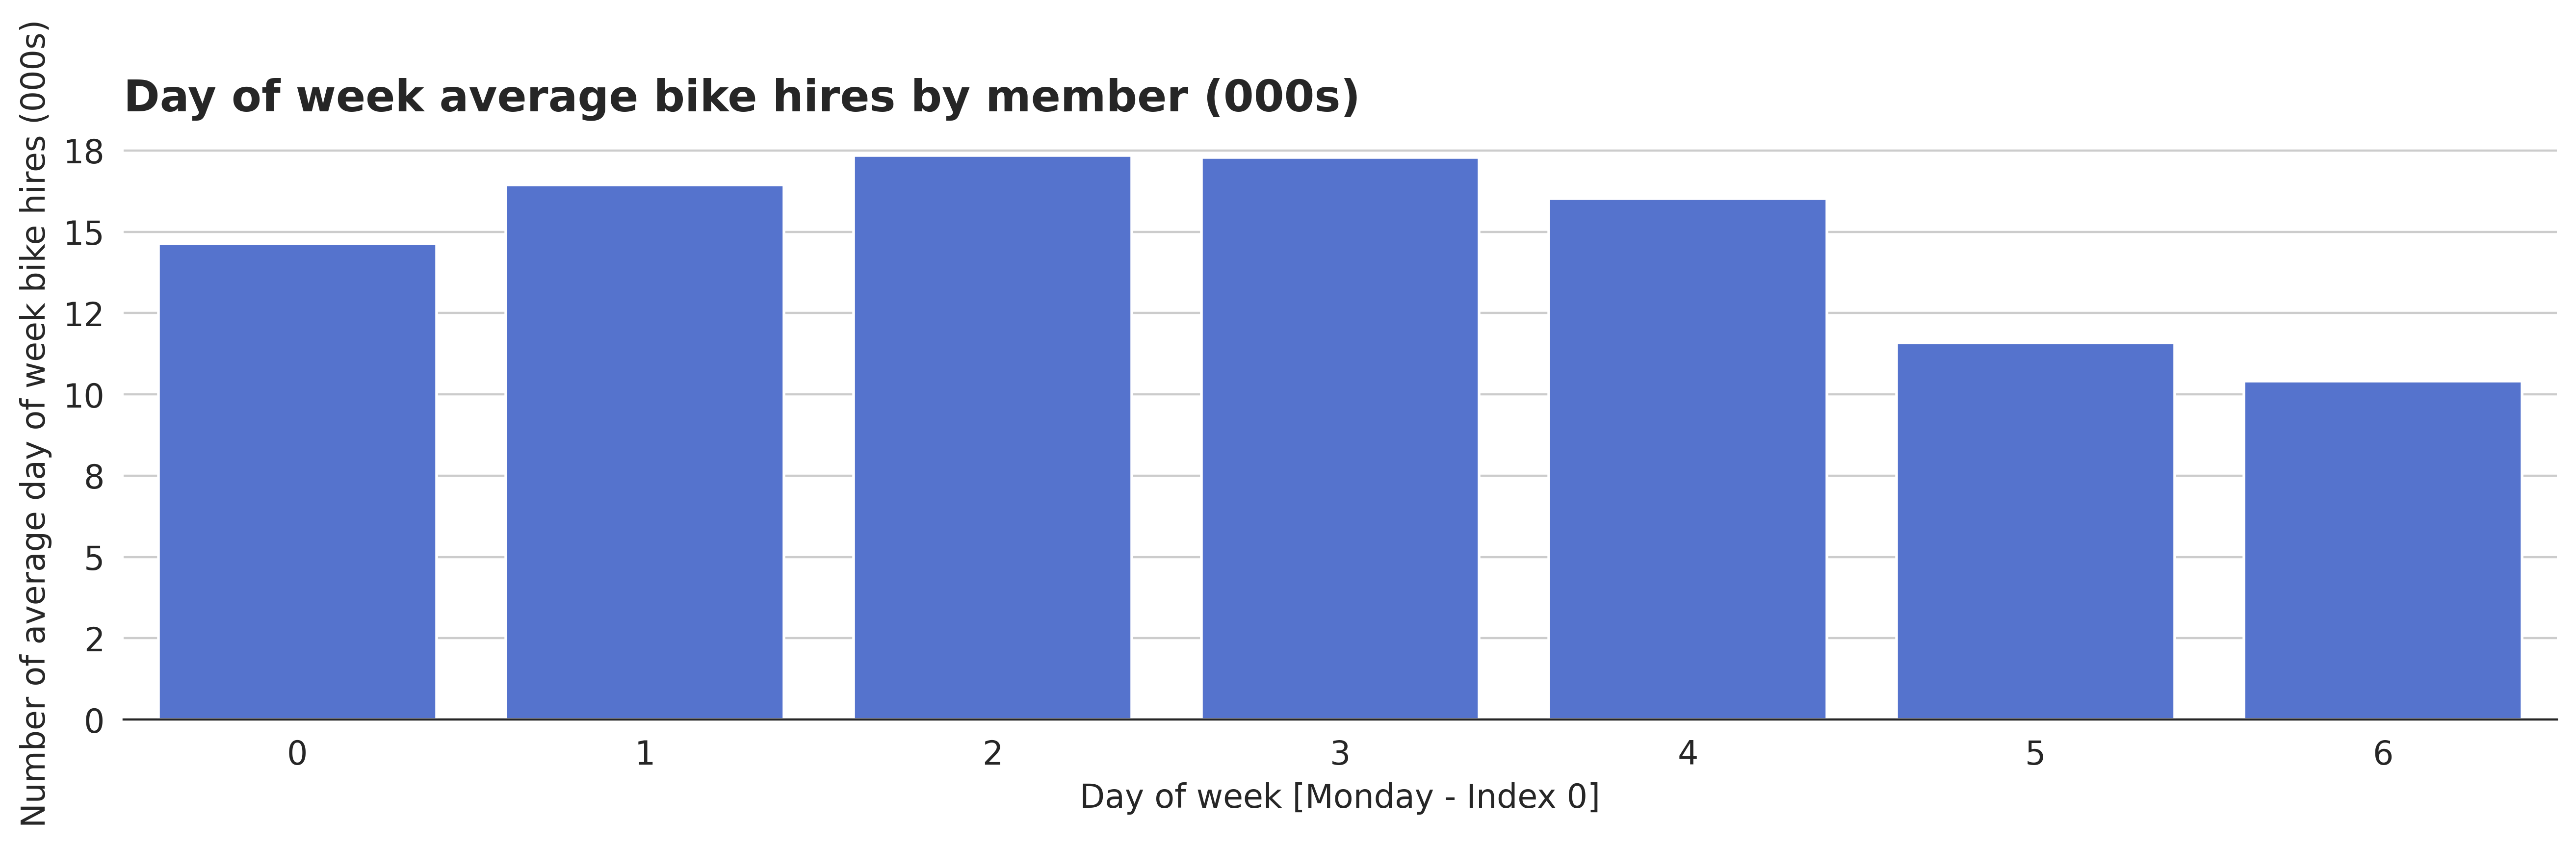

In [17]:
counts_per_member = overview.groupby(["is_member", overview.index])['is_member'].count().to_frame("count")
counts_per_member.reset_index(inplace=True)
counts_per_member.columns = ["is_member", "start_date", "counts"]
day_of_week_average_per_member = counts_per_member.groupby(["is_member", counts_per_member["start_date"].dt.dayofweek]).mean().reset_index()
for idx, _ in enumerate(membership): 
    plot_barchart_averages(
    day_of_week_average_per_member.loc[day_of_week_average_per_member.is_member==idx, ["start_date", "counts"]],
    title=f"Day of week average bike hires by {membership[idx]}",
    ylabel="Number of average day of week bike hires",
    xlabel="Day of week [Monday - Index 0]")